In [23]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict ,Annotated,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator
import os

In [24]:
load_dotenv()
model = ChatOpenAI(model=os.getenv("MODEL_NAME"))

In [25]:
positive_review = "I really enjoyed using this product. It exceeded my expectations and I am extremely satisfied with my purchase."
negative_review = "I was disappointed with this product. It did not meet my expectations and I am not satisfied with it."

In [26]:
class SentimentSchema(BaseModel):
    sentiment:str = Field(description="is this review positive or negative")

sentiment_model = model.with_structured_output(SentimentSchema)
# print(sentiment_model.invoke(positive_review).sentiment)
# print(sentiment_model.invoke(negative_review).sentiment)

In [27]:
class NegativeReviewBreakdown(BaseModel):
    issue_type: str = Field(description="what is the issue with the product")
    topic: str = Field(description="what is the tone of the customer")
    urgency: str = Field(description="what is the urgency of the issue")

negative_review_breakdown_model = model.with_structured_output(NegativeReviewBreakdown)
# response = negative_review_breakdown_model.invoke(negative_review)
# print(response.issue_type)
# print(response.topic)
# print(response.urgency)

In [28]:
class CustomerReviewState(TypedDict):
    review: str
    sentiment: str
    diagnostics: NegativeReviewBreakdown
    negative_review_reply: str
    positive_review_reply: str

In [29]:
def find_sentiment(state:CustomerReviewState)->CustomerReviewState:
    sentiment = sentiment_model.invoke(state["review"]).sentiment
    return {"sentiment":sentiment}

In [30]:
def run_diagnostics(state:CustomerReviewState)->CustomerReviewState:
    diagnostics = negative_review_breakdown_model.invoke(state["review"])
    return {"diagnostics":diagnostics}


In [37]:
def generate_negative_reply(state:CustomerReviewState)->CustomerReviewState:
    prompt = f"""
    The customer has given a negative review.
    The review is as follows:
    {state["review"]}
    The breakdown of the review is as follows:
    {state["diagnostics"]}
    
    Now you need to reply to customer and tell them that you are sorry for the inconvenience.
    """
    reply = model.invoke(prompt).content
    return {"negative_review_reply":reply}


In [38]:
def generate_positive_reply(state:CustomerReviewState)->CustomerReviewState:
    prompt = f"""
    The customer has given a positive review.
    The review is as follows:
    {state["review"]}
    
    Now you need to reply to customer and thank them for their review.
    """
    reply = model.invoke(prompt).content
    return {"positive_review_reply":reply}

In [39]:
def check_sentiment(state:CustomerReviewState)->Literal["generate_positive_reply","run_diagnostics"]:
    if state["sentiment"] == "positive":
        return "generate_positive_reply"
    else:
        return "run_diagnostics"
    

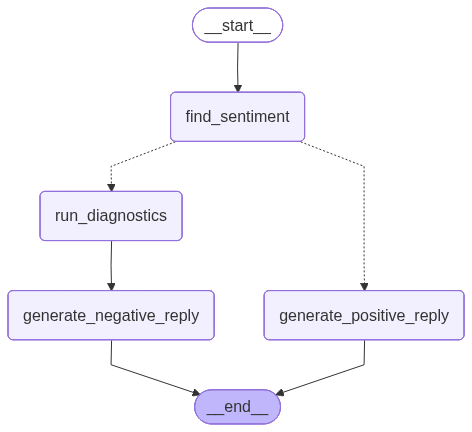

In [40]:
graph = StateGraph(CustomerReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("run_diagnostics", run_diagnostics)
graph.add_node("generate_negative_reply", generate_negative_reply)
graph.add_node("generate_positive_reply", generate_positive_reply)

graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges(
    "find_sentiment",
    check_sentiment,
    # {
    #     "positive_response": "generate_positive_reply",
    #     "run_diagnostics": "run_diagnostics"
    # }
)
graph.add_edge("run_diagnostics", "generate_negative_reply")
graph.add_edge("generate_negative_reply", END)
graph.add_edge("generate_positive_reply", END)

workflow = graph.compile()
workflow

In [41]:
init_state = {"review":positive_review}
workflow.invoke({"review":positive_review})

{'review': 'I really enjoyed using this product. It exceeded my expectations and I am extremely satisfied with my purchase.',
 'sentiment': 'positive',
 'positive_review_reply': "Hi there,\n\nThank you so much for your wonderful review! We're thrilled to hear that you enjoyed the product and that it exceeded your expectations. We truly appreciate your support. If you need any assistance or have questions in the future, we're here to help.\n\nThanks again for choosing us!"}

In [42]:
init_state = {"review":negative_review}
workflow.invoke(init_state)

{'review': 'I was disappointed with this product. It did not meet my expectations and I am not satisfied with it.',
 'sentiment': 'negative',
 'diagnostics': NegativeReviewBreakdown(issue_type='Product did not meet expectations', topic='disappointed', urgency='low'),
 'negative_review_reply': 'Hello, I’m sorry to hear that the product didn’t meet your expectations and that you’re not satisfied. We’d like to make this right. \n\nPlease reply with your order number and a brief description of what didn’t meet your expectations (e.g., quality, functionality, damage). We can offer a refund, a replacement, or another solution you prefer. \n\nThank you for sharing this with us—your feedback helps us improve, and we’ll take care of this promptly once we have the details.'}